In [1]:
import os
import shutil
from tqdm import tqdm

In [ ]:
import requests
import zipfile
import os
import urllib3

# Suppress the InsecureRequestWarning
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# URL and paths
url = "https://weiss-develop.cs.ucl.ac.uk/DeSmoke-LAP/DeSmoke-LAP_dataset.zip"
zip_path = "DeSmoke-LAP_dataset.zip"
extract_dir = "/content/drive/"

# Step 1: Download with SSL verification disabled
print("Downloading dataset (SSL verification disabled)...")
response = requests.get(url, stream=True, verify=False)
with open(zip_path, 'wb') as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)
print("Download complete.")

# Step 2: Extract the zip file
print("Extracting the dataset...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Extraction complete.")


In [5]:
# Paths to the base directory and output folders
base_dir = "DeSmoke-LAP dataset/Dataset/"
output_hazy = "Consolidated_Hazy_Images/"
output_clear = "Consolidated_Clear_Images/"
output_test = "Consolidated_Test_Clips/"

In [6]:
# Create output directories if they don't exist
os.makedirs(output_hazy, exist_ok=True)
os.makedirs(output_clear, exist_ok=True)
os.makedirs(output_test, exist_ok=True)

In [7]:
# Loop through all TLH folders
for tlh_folder in tqdm(os.listdir(base_dir), desc="Processing TLH folders"):
    tlh_path = os.path.join(base_dir, tlh_folder)
    if os.path.isdir(tlh_path):
        # Process hazy images
        hazy_folder = os.path.join(tlh_path, "hazy")
        if os.path.exists(hazy_folder):
            for file_name in os.listdir(hazy_folder):
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    src_file = os.path.join(hazy_folder, file_name)
                    dest_file = os.path.join(output_hazy, f"{tlh_folder}_{file_name}")
                    shutil.copy(src_file, dest_file)

        # Process clear images
        clear_folder = os.path.join(tlh_path, "clear")
        if os.path.exists(clear_folder):
            for file_name in os.listdir(clear_folder):
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    src_file = os.path.join(clear_folder, file_name)
                    dest_file = os.path.join(output_clear, f"{tlh_folder}_{file_name}")
                    shutil.copy(src_file, dest_file)

        # Process test clips
        test_folder = os.path.join(tlh_path, "test_clip")
        if os.path.exists(test_folder):
            for file_name in os.listdir(test_folder):
                if file_name.endswith(('.png', '.jpg', '.jpeg', '.mp4', '.avi')):
                    src_file = os.path.join(test_folder, file_name)
                    dest_file = os.path.join(output_test, f"{tlh_folder}_{file_name}")
                    shutil.copy(src_file, dest_file)

print("Data consolidated successfully!")
print(f"Hazy images: {output_hazy}")
print(f"Clear images: {output_clear}")
print(f"Test clips: {output_test}")

Processing TLH folders: 100%|██████████| 11/11 [00:03<00:00,  2.86it/s]

Data consolidated successfully!
Hazy images: Consolidated_Hazy_Images/
Clear images: Consolidated_Clear_Images/
Test clips: Consolidated_Test_Clips/


### Data Preview and Validation
- Before starting model training, preview and inspect the dataset.

#### Preview Random Images

In [8]:
import random
from PIL import Image
import matplotlib.pyplot as plt

# Preview random images from a folder
def preview_random_images(folder_path, num_images=3):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, min(len(image_files), num_images))
    
    plt.figure(figsize=(10, 5))
    for i, file_name in enumerate(selected_files):
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(file_name)
    plt.show()

Hazy Images


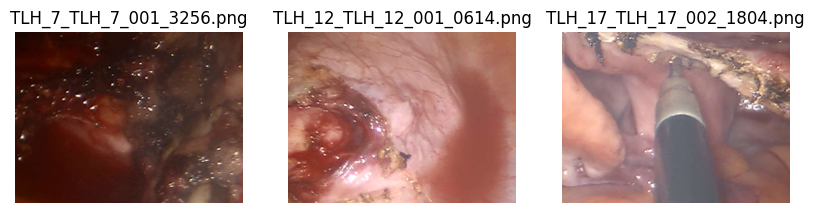

Clear Images


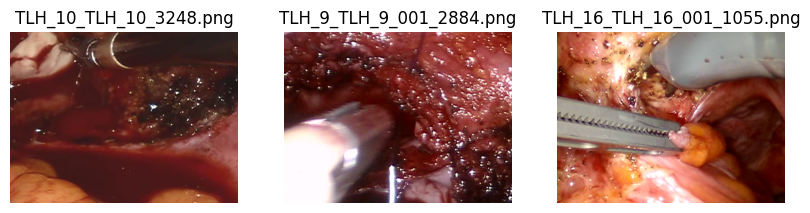

In [9]:
# Preview hazy and clear images
print("Hazy Images")
preview_random_images(output_hazy, num_images=3)  # Hazy images
print("Clear Images")
preview_random_images(output_clear, num_images=3)  # Clear images

#### Print Image Sizes

In [11]:
#Check the dimensions of a few random images to ensure they are consistent and suitable for training
def print_image_sizes(folder_path, num_images=3):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    selected_files = random.sample(image_files, min(len(image_files), num_images))

    for file_name in selected_files:
        image_path = os.path.join(folder_path, file_name)
        image = Image.open(image_path)
        print(f"Image: {file_name} | Size: {image.size} (Width x Height)")

# Example usage
print_image_sizes(output_hazy)

print_image_sizes(output_clear)


Image: TLH_17_TLH_17_002_4996.png | Size: (720, 540) (Width x Height)
Image: TLH_8_TLH_8_001_1903.png | Size: (720, 540) (Width x Height)
Image: TLH_2_TLH_2_001_1167.png | Size: (480, 360) (Width x Height)
Image: TLH_2_TLH_2_001_1128.png | Size: (480, 360) (Width x Height)
Image: TLH_9_TLH_9_001_0508.png | Size: (720, 540) (Width x Height)
Image: TLH_7_TLH_7_001_5552.png | Size: (720, 540) (Width x Height)


#### Detect if there are any corrupt or unreadable files in the dataset.

In [12]:
# Function to check for corrupt images
def check_corrupt_images(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    corrupt_files = []

    for file_name in image_files:
        image_path = os.path.join(folder_path, file_name)
        try:
            with Image.open(image_path) as img:
                img.verify()  # Verify if the file can be opened
        except Exception as e:
            print(f"Corrupt file detected: {file_name} | Error: {e}")
            corrupt_files.append(file_name)

    if corrupt_files:
        print(f"Total corrupt files: {len(corrupt_files)}")
    else:
        print("No corrupt images found.")

# Example usage
check_corrupt_images(output_hazy)

No corrupt images found.


#### Count total images

In [ ]:
import os

# Function to count images in a folder
def count_images(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    return len(image_files)

# Print the count of images in each folder
print(f"Hazy images count: {count_images(output_hazy)}")
print(f"Clear images count: {count_images(output_clear)}")
print(f"Test clips count: {count_images(output_test)}")

Hazy images count: 3000
Clear images count: 3000
Test clips count: 500


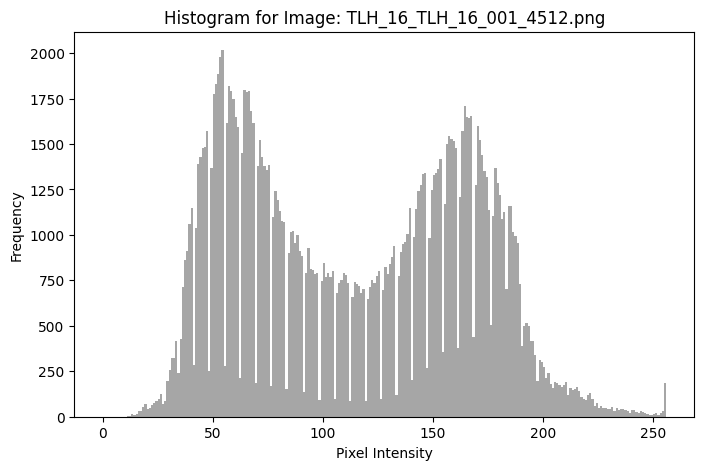

In [14]:
#Visualize the intensity distribution (histogram) of an image to analyze brightness or contrast issues.
# Function to display the histogram of an image
def display_image_histogram(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random_image = random.choice(image_files)

    image_path = os.path.join(folder_path, random_image)
    image = Image.open(image_path).convert("L")  # Convert to grayscale

    plt.figure(figsize=(8, 5))
    plt.hist(image.getdata(), bins=256, range=(0, 256), color='gray', alpha=0.7)
    plt.title(f"Histogram for Image: {random_image}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Example usage
display_image_histogram(output_hazy)

#### Visualize the intensity distribution (histogram) of an image to analyze brightness or contrast issues.

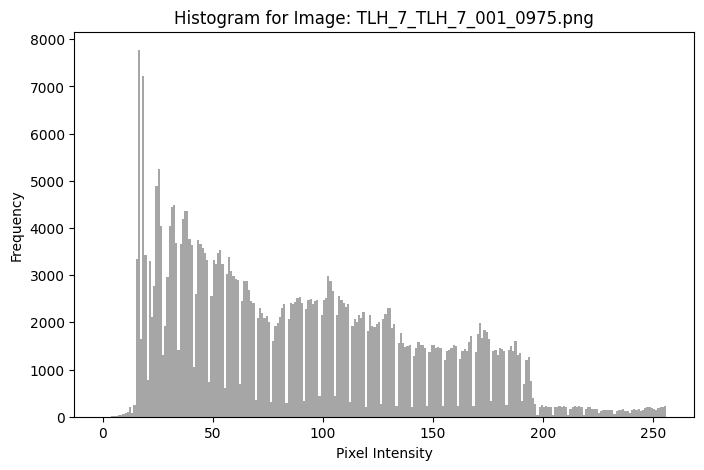

In [15]:
# Function to display the histogram of an image
def display_image_histogram(folder_path):
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random_image = random.choice(image_files)

    image_path = os.path.join(folder_path, random_image)
    image = Image.open(image_path).convert("L")  # Convert to grayscale

    plt.figure(figsize=(8, 5))
    plt.hist(image.getdata(), bins=256, range=(0, 256), color='gray', alpha=0.7)
    plt.title(f"Histogram for Image: {random_image}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Example usage
display_image_histogram(output_hazy)